# CS4048 – Assignment 3

Complete assignment (Problem 1 & Problem 2) using the provided PakWheels dataset.


In [1]:
# Load libraries and dataset
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import scipy.stats as stats
import math

df = pd.read_csv("pakwheels.csv")
df.shape

(89956, 17)

In [2]:
# Data cleaning and feature extraction

df.columns = [c.strip() for c in df.columns]

# parse price
import numpy as np

def parse_price(x):
    if pd.isna(x): return np.nan
    s = str(x).replace(',','').strip()
    s = s.replace('PKR','').strip()
    if 'lacs' in s.lower():
        try:
            return float(s.lower().replace('lacs','').strip()) * 100000
        except:
            return np.nan
    try:
        return float(''.join(ch for ch in s if (ch.isdigit() or ch=='.')))
    except:
        return np.nan

def parse_mileage(x):
    if pd.isna(x): return np.nan
    s = str(x).lower().replace(',','').strip()
    s = s.replace('km','').strip()
    try:
        return float(''.join(ch for ch in s if (ch.isdigit() or ch=='.')))
    except:
        return np.nan

def parse_engine(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if 'cc' in s:
        try:
            return float(''.join(ch for ch in s if (ch.isdigit() or ch=='.')))
        except:
            return np.nan
    try:
        return float(''.join(ch for ch in s if (ch.isdigit() or ch=='.')))
    except:
        return np.nan

def parse_year(x):
    try:
        return int(x)
    except:
        try:
            return int(''.join(ch for ch in str(x) if ch.isdigit())[:4])
        except:
            return np.nan

def extract_brand(t):
    if pd.isna(t): return t
    s = str(t).strip()
    tokens = s.split()
    if len(tokens)>0:
        return tokens[0].title()
    return s


df['price_num'] = df['price'].apply(parse_price)
df['mileage_num'] = df['mileage'].apply(parse_mileage)
df['engine_cc'] = df.get('engine_capacity', pd.Series([np.nan]*len(df))).apply(parse_engine)
df['model_year_num'] = df['model_year'].apply(parse_year)
df['brand'] = df['title'].apply(extract_brand)

df = df[df['price_num'].notna()].copy()
df.reset_index(drop=True, inplace=True)

df[['price_num','mileage_num','engine_cc','model_year_num','brand']].head()


,price_num,mileage_num,engine_cc,model_year_num,brand
0,1650000.0,100000.0,1800.0,2007.0,Honda
1,700000.0,100000.0,800.0,2012.0,Suzuki
2,760000.0,999.0,1500.0,1995.0,Honda
3,7000000.0,94000.0,2700.0,2013.0,Toyota
4,800000.0,86000.0,796.0,2015.0,Suzuki


          price_num     mileage_num     engine_cc  model_year_num
count  8.854900e+04    88549.000000  88549.000000    86046.000000
mean   2.465403e+06    85061.127782   1398.680950     2012.767020
std    1.888061e+06    90745.182346    731.660795        7.671057
min    1.000000e+00        1.000000     16.500000     1990.000000
25%    1.050000e+06    20000.000000   1000.000000     2007.000000
50%    2.000000e+06    75000.000000   1300.000000     2014.000000
75%    3.350000e+06   120000.000000   1600.000000     2019.000000
max    1.000000e+07  1000000.000000  15000.000000     2022.000000

Skewness:
price_num         1.276511
mileage_num       3.993176
engine_cc         4.680423
model_year_num   -0.763805
dtype: float64

Top brands:
brand
Toyota        28512
Suzuki        26715
Honda         17207
Daihatsu       3147
Kia            2515
Nissan         1717
Hyundai        1632
Changan        1354
Mitsubishi     1207
Mercedes        707
Name: count, dtype: int64


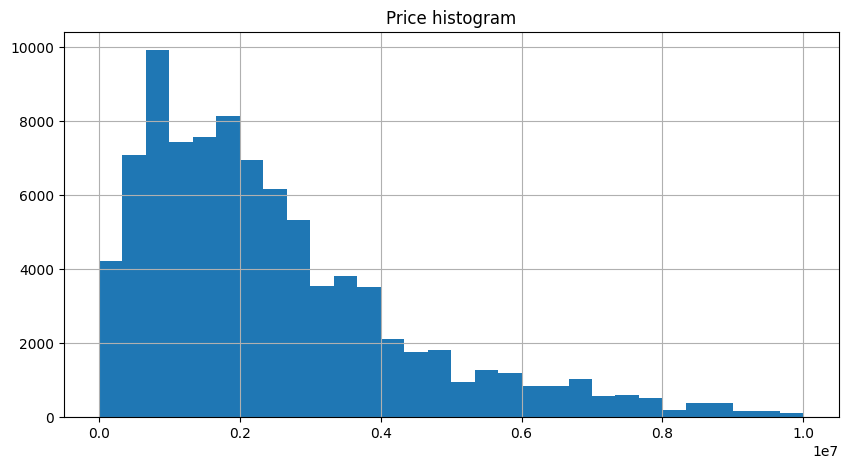

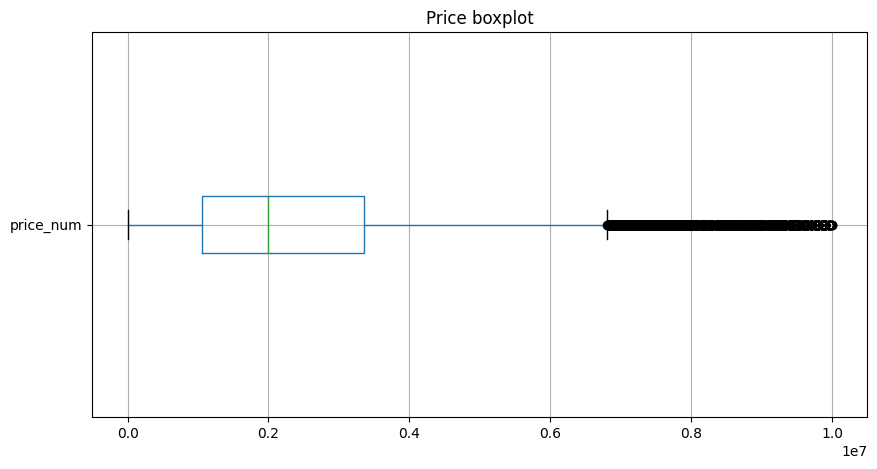

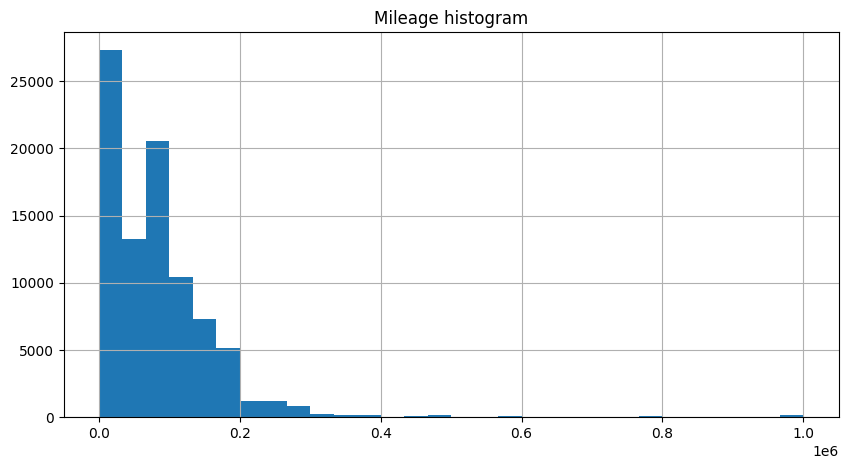

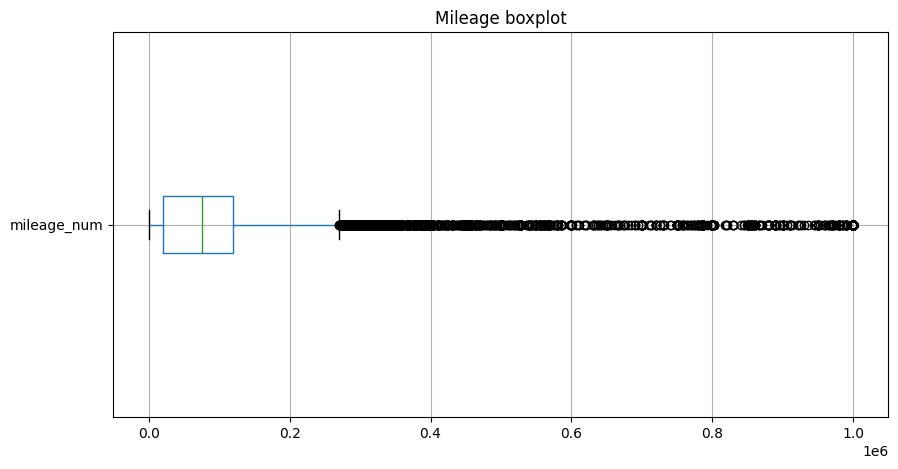

In [3]:
# (a) Descriptive statistics and visualizations
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,5)

print(df[['price_num','mileage_num','engine_cc','model_year_num']].describe())
print('\nSkewness:')
print(df[['price_num','mileage_num','engine_cc','model_year_num']].skew())

# Top brands
print('\nTop brands:')
print(df['brand'].value_counts().nlargest(10))

# Histograms
df['price_num'].hist(bins=30); plt.title('Price histogram'); plt.show()
df.boxplot(column='price_num', vert=False); plt.title('Price boxplot'); plt.show()

df['mileage_num'].hist(bins=30); plt.title('Mileage histogram'); plt.show()
df.boxplot(column='mileage_num', vert=False); plt.title('Mileage boxplot'); plt.show()



In [4]:
# (b) One-sample t-test: test mean price != PKR 1,000,000
from scipy import stats
import math
sample = df['price_num'].dropna()
popmean = 1000000.0
n = len(sample)
mean = sample.mean()
std = sample.std(ddof=1)
se = std/math.sqrt(n)
t_stat, p_value = stats.ttest_1samp(sample, popmean)
ci = stats.t.interval(0.95, df=n-1, loc=mean, scale=se)
print('n=',n,'mean=',mean,'std=',std)
print('t_stat=',t_stat,'p_value=',p_value)
print('95% CI for mean=',ci)


n= 88549 mean= 2465402.5470365556 std= 1888060.9488691643
t_stat= 230.95786850503615 p_value= 0.0
95% CI for mean= (np.float64(2452966.618815268), np.float64(2477838.4752578433))


In [5]:
# (c) Two-sample comparison: Automatic vs Manual (price)
grp = df[df['transmission'].notna()].copy()
auto = grp[grp['transmission'].str.contains('Auto', case=False, na=False)]['price_num'].dropna()
man = grp[grp['transmission'].str.contains('Manual', case=False, na=False)]['price_num'].dropna()
print('counts: auto=',len(auto),'manual=',len(man))

from scipy import stats
# Welch's t-test
t_stat, p_value = stats.ttest_ind(auto, man, equal_var=False)
# Welch df
def welch_df(a,b):
    sa=a.var(ddof=1); sb=b.var(ddof=1); na=a.size; nb=b.size
    num=(sa/na+sb/nb)**2
    den=(sa*sa)/(na*na*(na-1)) + (sb*sb)/(nb*nb*(nb-1))
    return num/den

df_w = welch_df(auto, man)
crit = stats.t.ppf(1-0.025, df_w)
print('t_stat=',t_stat,'p_value=',p_value,'df_approx=',df_w,'crit_t(0.975)=',crit)

# Bootstrap CI for difference in means
import numpy as np
rng = np.random.default_rng(0)
iters=1000
diffs=[]
for i in range(iters):
    a=rng.choice(auto,size=len(auto),replace=True)
    b=rng.choice(man,size=len(man),replace=True)
    diffs.append(a.mean()-b.mean())
ci_lower=np.percentile(diffs,2.5); ci_upper=np.percentile(diffs,97.5)
print('Bootstrap 95% CI for mean(auto)-mean(man)=', (ci_lower,ci_upper))


counts: auto= 45273 manual= 43276
t_stat= 185.98087569921057 p_value= 0.0 df_approx= 61411.81492233541 crit_t(0.975)= 1.9600026141945295
Bootstrap 95% CI for mean(auto)-mean(man)= (np.float64(1957643.7359628412), np.float64(1999724.482059836))


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create brand column
df["brand"] = df["title"].astype(str).str.split().str[0]

# Select top brands
top_brands = df['brand'].value_counts().nlargest(4).index.tolist()
print("\nTop brands:", top_brands)

# Prepare data groups
groups = [df[df['brand']==b]['price_num'].dropna() for b in top_brands]

# Shapiro test
shapiro_results = {}
for b in top_brands:
    data = df[df['brand']==b]['price_num'].dropna()
    if len(data) >= 3:
        shapiro_results[b] = stats.shapiro(data)
    else:
        shapiro_results[b] = ("Not enough data", None)

print("\nShapiro results:")
for b,v in shapiro_results.items():
    print(b, "→", v)

# Levene variance test
levene_stat, levene_p = stats.levene(*groups, center='median')
print("\nLevene test p-value =", levene_p)

# Decide ANOVA or Kruskal
use_anova = all((shapiro_results[b][1] is not None and shapiro_results[b][1] > 0.05)
                for b in top_brands) and (levene_p > 0.05)

print("\nUse ANOVA?", use_anova)

if use_anova:
    f_stat, p_val = stats.f_oneway(*groups)
    print("\nANOVA: F =", f_stat, "p =", p_val)
else:
    kw_stat, kw_p = stats.kruskal(*groups)
    p_val = kw_p
    print("\nKruskal-Wallis: H =", kw_stat, "p =", p_val)



Top brands: ['Toyota', 'Suzuki', 'Honda', 'Daihatsu']

Shapiro results:
Toyota → ShapiroResult(statistic=np.float64(0.9451622057806599), pvalue=np.float64(4.022519829401673e-71))
Suzuki → ShapiroResult(statistic=np.float64(0.9232941052840105), pvalue=np.float64(4.452422155976208e-77))
Honda → ShapiroResult(statistic=np.float64(0.9367071486536047), pvalue=np.float64(4.128496692578946e-64))
Daihatsu → ShapiroResult(statistic=np.float64(0.9186388342521404), pvalue=np.float64(3.197648326685095e-38))

Levene test p-value = 0.0

Use ANOVA? False

Kruskal-Wallis: H = 18365.60850811061 p = 0.0


c:\Users\Huzaifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 28512.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Huzaifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26715.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Huzaifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17207.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
#(e) significance level effect
print("\nEffect of significance level:")
for alpha in [0.05, 0.01]:
    if p_val < alpha:
        print(f"alpha = {alpha}: Reject H0 (significant difference)")
    else:
        print(f"alpha = {alpha}: Fail to reject H0 (no significant difference)")



Effect of significance level:
alpha = 0.05: Reject H0 (significant difference)
alpha = 0.01: Reject H0 (significant difference)


n: 86046
                price_num  mileage_num  engine_cc  model_year_num
price_num        1.000000    -0.252320   0.308529        0.494234
mileage_num     -0.252320     1.000000   0.042411       -0.457643
engine_cc        0.308529     0.042411   1.000000       -0.073521
model_year_num   0.494234    -0.457643  -0.073521        1.000000


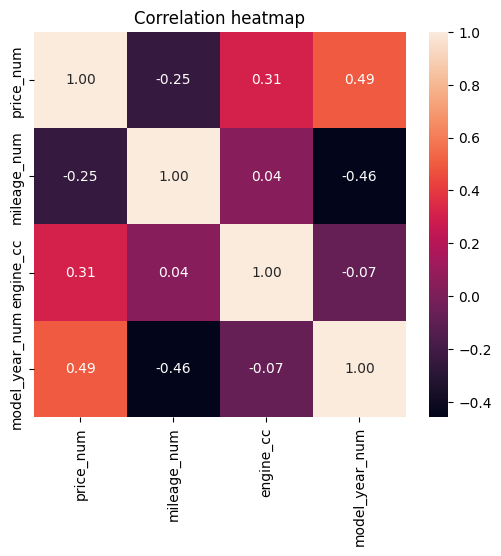

{'price_num__mileage_num': {'r': np.float64(-0.2523202768282063),
  'p': np.float64(0.0),
  'ci': (-0.25856600823197085, -0.2460534502991303),
  'n': 86046},
 'price_num__engine_cc': {'r': np.float64(0.30852934091093875),
  'p': np.float64(0.0),
  'ci': (0.30247122897474826, 0.3145625268095085),
  'n': 86046},
 'price_num__model_year_num': {'r': np.float64(0.49423448738176645),
  'p': np.float64(0.0),
  'ci': (0.48916821694102897, 0.4992674072373433),
  'n': 86046},
 'mileage_num__engine_cc': {'r': np.float64(0.04241098285243231),
  'p': np.float64(1.4687239377354037e-35),
  'ci': (0.0357394584864863, 0.04907872719736435),
  'n': 86046},
 'mileage_num__model_year_num': {'r': np.float64(-0.4576433907671287),
  'p': np.float64(0.0),
  'ci': (-0.46290955155619734, -0.4523449253170949),
  'n': 86046},
 'engine_cc__model_year_num': {'r': np.float64(-0.07352128616889544),
  'p': np.float64(1.9861409480743355e-103),
  'ci': (-0.08016355838006295, -0.0668724848021982),
  'n': 86046}}

In [6]:
# (f) Correlations: compute Pearson r, p-values, 95% CI using Fisher transform
num_cols = ['price_num','mileage_num','engine_cc','model_year_num']
sub = df[num_cols].dropna()
print('n:',len(sub))
print(sub.corr())

# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(sub.corr(), annot=True, fmt='.2f')
plt.title('Correlation heatmap')
plt.show()

# Pairwise r, p, CI
from math import atanh, tanh, sqrt
results = {}
for i in range(len(num_cols)):
    for j in range(i+1,len(num_cols)):
        a=num_cols[i]; b=num_cols[j]
        x=sub[a].values; y=sub[b].values
        r,p = stats.pearsonr(x,y)
        n=len(x)
        zr = np.arctanh(r)
        se = 1/math.sqrt(n-3)
        z = stats.norm.ppf(0.975)
        ci_lo = math.tanh(zr - z*se); ci_hi = math.tanh(zr + z*se)
        results[f'{a}__{b}']={'r':r,'p':p,'ci':(ci_lo,ci_hi),'n':n}
results


In [7]:
# (g) Bootstrapping correlation between price and mileage
x = sub['price_num'].values; y = sub['mileage_num'].values
rng = np.random.default_rng(42)
boot_r = []
n = len(x)
for _ in range(1000):
    idx = rng.integers(0,n,n)
    boot_r.append(stats.pearsonr(x[idx], y[idx])[0])
boot_ci = (np.percentile(boot_r,2.5), np.percentile(boot_r,97.5))
print('Bootstrap 95% CI for r:', boot_ci)


Bootstrap 95% CI for r: (np.float64(-0.2575855350561841), np.float64(-0.2470962081901366))


# Problem 2 — Spurious Correlations

(a) Example: Tyler Vigen's spurious correlations gallery contains many examples where two unrelated time series correlate strongly. Insert image manually if required.

(b) Learning: Spurious correlations can arise by coincidence, multiple testing, or confounding. They are common in large variable sets and require domain knowledge to disambiguate.


r= 0.9701613776943344 p= 0.0 n= 88549


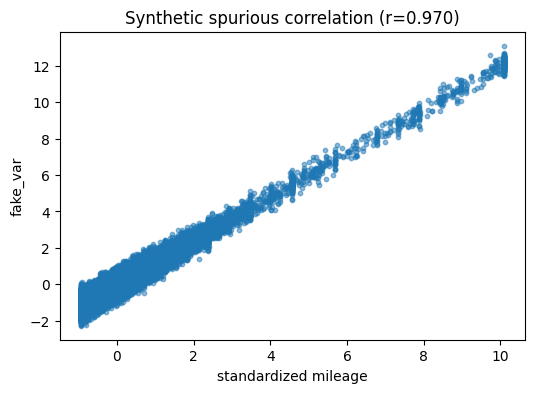

In [8]:
# (c) Create new spurious correlation with r >= 0.8 using dataset
import numpy as np
rng = np.random.default_rng(7)
base = df['mileage_num'].dropna().values
# standardize
b = (base - base.mean())/base.std()
# create fake variable with strong linear relation plus small noise
fake = 1.2*b + rng.normal(0, 0.3, size=b.shape)
# compute correlation
r,p = stats.pearsonr(b, fake)
print('r=',r,'p=',p,'n=',len(b))
# scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(b, fake, s=10, alpha=0.5)
plt.title('Synthetic spurious correlation (r={:.3f})'.format(r))
plt.xlabel('standardized mileage'); plt.ylabel('fake_var'); plt.show()


In [9]:
# (d) 95% CI for correlation (Fisher) and p-value
r_obs, p_obs = stats.pearsonr(b, fake)
n = len(b)
zr = np.arctanh(r_obs)
se = 1/math.sqrt(n-3)
z = stats.norm.ppf(0.975)
ci_lo = math.tanh(zr - z*se); ci_hi = math.tanh(zr + z*se)
print('r=',r_obs,'p=',p_obs,'95% CI=',(ci_lo,ci_hi))


r= 0.9701613776943344 p= 0.0 95% CI= (0.9697716852776146, 0.9705461214586132)


In [10]:
# (e) Bootstrapped 95% CI for the correlation (1000 iterations)
rng = np.random.default_rng(8)
boot = []
n = len(b)
for _ in range(1000):
    idx = rng.integers(0,n,n)
    boot.append(stats.pearsonr(b[idx], fake[idx])[0])
boot_ci = (np.percentile(boot,2.5), np.percentile(boot,97.5))
print('Bootstrapped 95% CI for r:', boot_ci)


Bootstrapped 95% CI for r: (np.float64(0.9690523570436982), np.float64(0.971208242327101))
